Imports and settings when working on google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/github_projects/protein_structure_prediction

/content/drive/MyDrive/github_projects/protein_structure_prediction


## __proteinSSpredictor__

This projects constitutes a final project for Data Science Bootcamp organised by Sages and aims at providing a deep-learning-based approach to predict secondary structure of the protein based on its primary sequence of the amino acids.

## __Table of contents__
1. Abstract
2. Source of raw sequences
3. Curation of the dataset
4. Prerequisites
5. Raw data processing
6. Exploration of preprocessed dataset for modeling
7. Sequences representation for modeling
8. Building a model
9. Where is the model making errors?
10. Summary
11. References

## __1. Abstract__

to do
-write the need for the prediction methods as the grow of the sequences amount is much higher compared to grow of the amount of structures due to time and cost

## __2. Source of raw sequences__

Preparation of the updated dataset analogous to https://www.kaggle.com/alfrandom/protein-secondary-structure

Following steps from https://github.com/zyxue/pdb-secondary-structure the secondary structure data was downloaded by

`DATE_STAMP=$(date  +'%Y-%m-%d')
wget https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz -O ${DATE_TAMP}-ss.txt.gz`

Further, data was transformed to csv file analogously to https://github.com/zyxue/pdb-secondary-structure using self-implemented method (see below for more details).

## __3. Curation of the sequence dataset__ 

Further, recent PISCES data with removed peptides with high sequence similarity was downloaded from http://dunbrack.fccc.edu/Guoli/pisces_download.php

Selected precompiled CulledPDB for further modeling was generated with following criteria:

- percentage identity cutoff: 30%
- the resolution cutoff:      2.0 Å
- the R-factor cutoff:        0.25
- date of generation:         2021/07/02
- the number of sequences:    10870


## __4. Prerequisites__

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

## __5. Raw data processing__
At this point the raw sequences were converted to CSV file, translated to 3 letters representation, and combined with culledPDB list with reduced sequence identity to improve the model quality

In [5]:
from tools import process_raw_data

In [6]:
processing = process_raw_data.Sequences()

In [7]:
# %time sequences_df = processing.process_raw_sequences('../data/2021-07-09-ss.txt.gz')

In [8]:
#optional for faster processing:
sequences_df = pd.read_csv('../data/2021-07-09-ss.csv')

The set of raw sequences before processing with CulledPDB dataset contains 477154 and includes information about the sequence PDB ID code, protein chain and its primary sequence together with the secondary structure sequence

In [9]:
sequences_df.shape

(477154, 4)

In [10]:
sequences_df.head()

,pdb_id,chain,sequence,secondary_struct
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...


In [11]:
pisces_df = processing.clean_pisces(pisces_file='../data/cullpdb_pc30_res2.0_R0.25_d2021_07_02_chains10870.gz')

In [12]:
pisces_df.head()

,length,source,resolution,R_value,R_free,pdb_id,chain
0,108,XRAY,2.0,0.21,0.25,1A1X,A
1,148,XRAY,1.8,0.19,0.24,1A3A,A
2,163,XRAY,1.8,0.21,0.30,1A73,A
3,226,XRAY,1.9,0.19,0.22,1A8L,A
4,1073,XRAY,1.8,0.19,1.00,1A9X,C


The culledPDB set containts 10870 items (PDB databases records filtered by the resolution, R-value and the 30% sequence identity). It contains information about protein PDB ID code, protein chain, method used for its determination, R-value, R-value free and the length of the sequence.

In [13]:
pisces_df.shape

(10870, 7)

In [14]:
combined_df = processing.combine_pdb_pisces(sequences_df=sequences_df, pisces_df=pisces_df)

In [15]:
combined_df.head()

,pdb_id,chain,sequence,secondary_struct,length,source,resolution,R_value,R_free
0,1A1X,A,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,108,XRAY,2.0,0.21,0.25
1,1A3A,A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,148,XRAY,1.8,0.19,0.24
2,1A73,A,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,163,XRAY,1.8,0.21,0.30
3,1A8L,A,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,226,XRAY,1.9,0.19,0.22
4,1A9X,F,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,379,XRAY,1.8,0.19,1.00


In [16]:
combined_df.shape

(10186, 9)

While intersecting raw sequences and culledPDB dataset by protein PDB ID codes and chains, we obtain slightly smaller set (10186) in then the original culledPDB (10870) due to some mismatches in the chain IDs

In [17]:
print(sorted(pisces_df.chain.unique()))
print(f'amount of unique chain IDs in PISCES dataset: {len(pisces_df.chain.unique())}')

['1', '2', '3', '4', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in PISCES dataset: 30


In [18]:
print(sorted(sequences_df.chain.unique()))
print(f'amount of unique chain IDs in dataset of raw sequences: {len(sequences_df.chain.unique())}')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in dataset of raw sequences: 36


As the protein secondary structure can be represented in the extended form containing 8 secondary structure types (Q8) and simplified, containing only 3 secondary structure types (Q3), we create new column with the simplified version for modeling

Q8: Q3

__helices__ G, H, I: H

__sheet__ B, E: E

__coil__ T, S, C: C

Additionally, we get rid of the remaining columns and keep just PDB ID code, sequence, extended (Q8) secondary structure representation and simplified (Q3) representation as pdb_id, seq, sst_q8 and sst_q3, respectively:

In [19]:
processes_sequeces = processing.generate_seq_q8_q3_representation(combined_df)

In [20]:
processes_sequeces

,pdb_id,seq,sst_q8,sst_q3
0,1A1X,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,CCCCCCCCCCCCEEEEEECCEEEECCCCEEEEEEEECCCCEEEEEE...
1,1A3A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,CCCCCCCCHHHEECCCCCCCHHHHHHHHHHHHHHCCCECCHHHHHH...
2,1A73,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,CCCCHHHHHHHHHHHHHHHCCCCEEEEEEEEECCEEEEEEEEECCC...
3,1A8L,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,CCCCCHHHHHHHHHHCHHHCCCCEEEEEEECCCCCCCHHHHHHHHH...
4,1A9X,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,CCEEEEEECCCCEEEEEECCCCEEEEEEEEEECCCCCHHHHHCCHH...
...,...,...,...,...
10181,7BU2,MSMIKSYAAKEAGGELEVYEYDPGELRPQDVEVQVDYCGICHSDLS...,CCCEEEEEESSTTCCEEEEEECCCSCCTTEEEEEEEEEEECHHHHH...,CCCEEEEEECCCCCCEEEEEECCCCCCCCEEEEEEEEEEECHHHHH...
10182,7BVD,MQTTANHSSRSTQTGTRAHGAALAETTSREDFRALATEHRVVPVIR...,CCCCCCCCCCCCCCCCCCCCCCTTCCCCHHHHHHHHTTCSEEEEEE...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHCCCCEEEEEE...
10183,7BYW,MRGSHHHHHHSGQRMGMVIGIKPEHIDEYKRLHAAVWPAVLARLAE...,CCCCCCCCCCCCCEEEEEEEECGGGHHHHHHHHTTCCHHHHHHHHH...,CCCCCCCCCCCCCEEEEEEEECHHHHHHHHHHHCCCCHHHHHHHHH...
10184,7ODC,MSSFTKDEFDCHILDEGFTAKDILDQKINEVSSSDDKDAFYVADLG...,CCEEEETTEEEEEECSSCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...,CCEEEECCEEEEEECCCCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...


Now, I am checking whether all representations of each protein in my dataset have complementary length

In [21]:
test_df = pd.DataFrame()
test_df['seq_len'] = [len(x) for x in processes_sequeces.seq]
test_df['sst_q8_len'] = [len(x) for x in processes_sequeces.sst_q8]
test_df['sst_q3_len'] = [len(x) for x in processes_sequeces.sst_q3]

In [22]:
processes_sequeces['pdb_id'][(test_df.seq_len != test_df.sst_q8_len) | (test_df.seq_len != test_df.sst_q3_len)]

Series([], Name: pdb_id, dtype: object)

In [23]:
processes_sequeces = processes_sequeces.assign(length=test_df.seq_len)

There are no mismatches between representations, hence I proceed further. Sequences can potentially contain non-standard amino acids (https://www.samformat.info/IUPAC-ambiguity-codes).

Standard set includes 20 types: 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'

Non-standard amino acids may include: 'B', 'J', 'O', 'U', 'Z' and 'X', where the last represents unspecified or unknown (potentially missing type). Let's have a look on those.

In [24]:
nonstandard_aa = 'BJOUZX'
contains_nonstandard_aa = []
nonstandard_types = []
for sequence in processes_sequeces.seq:
    i = 0
    ns_types = ''
    for letter in sequence:
        if letter in nonstandard_aa:
            i += 1
            ns_types += letter
    contains_nonstandard_aa.append(i)
    nonstandard_types.append(ns_types)
processes_sequeces = processes_sequeces.assign(contains_nonstandard_aa = contains_nonstandard_aa)
processes_sequeces = processes_sequeces.assign(nonstandard_types = nonstandard_types)

In [25]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 0].shape

(71, 7)

We can observe, that 71 sequences contain nonstandard amino amids, I will have a closer look at those which have more of them, focusing especially on the unknown (X) 

In [26]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 1]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
906,1SN9,XYRIPSYDFADELAKLLRQAAGX,CCEETTEEHHHHHHHHHHHHTCC,CCEECCEEHHHHHHHHHHHHCCC,23,2,XX
2135,2O5G,XARRKWQKTGHAVRAIGRLSX,CCHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHCC,21,2,XX
2140,2O6N,XAEIEQAKKEIAYLIKKAKEEILEEIKKAKQEIAX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,35,2,XX
2516,2RKZ,XETLTGQYDKNLVTTVEEEYDSX,CCCEEECSCTTSCCEEEEECCCC,CCCEEECCCCCCCCEEEEECCCC,23,2,XX
2801,2XSK,MGSSQITFNTTQQGDMYTIIPEVTLTQSULURVQILSLREGSSGQS...,CCCCEEEEEEEEETTEEEEEEEEECSSCEEEEEEEEEEEECSSCEE...,CCCCEEEEEEEEECCEEEEEEEEECCCCEEEEEEEEEEEECCCCEE...,110,2,UU
3210,3CAL,XKGIVTGAVSDHTTVEDTKX,CCCCEEECCSSCEEEECCCC,CCCCEEECCCCCEEEECCCC,20,2,XX
3213,3CAY,XAXAEAAEKAAKYAAEAAEKAAKAXAX,CCHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHCC,27,4,XXXX
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
5083,3W19,XNNLLRAIEAQQHLLQLTVWGIKQLQARILAVERYLKDQX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,40,2,XX


In [27]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 4]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
7112,4Z0W,XAPAPFVPAAXAVXLAXLAALXG,CCCTTTGGGGGGGGGGGGGGGCC,CCCCCCHHHHHHHHHHHHHHHCC,23,5,XXXXX
9174,6FHN,GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATG...,CCEEEEECCTTCEETTSCCEEEEEESSCCSCCEEEEESSSSEEEEE...,CCEEEEECCCCCEECCCCCEEEEEECCCCCCCEEEEECCCCEEEEE...,1009,33,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
9259,6GME,XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGEN...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHSCTTCEEEEECSSCTT...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHCCCCCEEEEECCCCCC...,201,18,XXXXXXXXXXXXXXXXXX


In [28]:
processes_sequeces.seq[processes_sequeces.pdb_id == '6FHN'].values

array(['GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATGTMKDEGYVWGKYVYSIDFSSVTATGTNFTIRSNGVSSYTFPIQTNMWNEYKDEMTAFYRLLRTTDTFAAYPAGYSNIAPSNKILHPDSFLDDAFSPDRTTHYDLTGGWFDAGDYGKYGGNQWVQGNIAISYLRHASSAAVNFDKDTNGIPDLVDEAIFGSQYLVKFANQLGGAIHNILRKGGFVLPHKVTDNVPGNTDDRALEAVEAVGGSGKSSGSLAATARAIRTAIAGGKVAANKVAQLQTLANEFQAAAIIFYNYTLTHQSGNHGSYGTMNNGGIANPLLWAEVQLYLLTGDAAYKTQAQTRINAINEAYVSSTNYWDMHPIALAEFYPVADSAIKTKIQSILKHQAYYFITLMDETPYGVLNQFGNFGVNEPHASYMADLLRYYELFNDPVALRAAKKALYWIVGNNPWNISWVSGVGSNFTDFLHTRLDEEAYSQTNTGVVLPGAMVSGPNIKDPNNKLSSSPWYEDKPIWADDTNQWRYNEYSVSIQTGLFYTIMGLSALGGNASTGGAEPVKLPITWPIIGDYVTGDVTVFAQPEGSLSNVSANGIVLSPSDGVYTTTVSTSADAPYTERKVQIKGTDDSGFTTYSNTHFTVAPALPDPSHPLLFDDFNQKGIWGSQKLDWVNWYNQNGGTASYTRTTVDTRTVGKFAHTPAATTSKAKFQPWKYNANLNGYRYLNFTMKNPGYPNTKIRIAANDGTKSVNLTSGEVAISSTWTTYQYDLNLHPTLNKSNVLIEVWLSNPTAGAYGEILIDEISAVNTNSGTAPTLSATGVNASIGNQSTVFTYTATYTDANNQAPFDVQVVIDGVIRSMTAADPTDTTYSDGRVYTYATTLPVGTHKFYFRTTDTTTNFVSTSVQTGPTVIRNKLEAEVLSINLTNYTHAVKDNADASGGKYRLFNGRQANDYIEYAVNVPKAGTYQVSAXXXXXXXXXXXXXXXXX

In [29]:
processes_sequeces.seq[processes_sequeces.pdb_id == '6GME'].values

array(['XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGENHLTVTWKVSDGIYQHVDVREEGKENAFSLGATLWINSEEFEDLDEIVARYVQPMASFARDLLNHKYYQDCSGGDRKKLEELLIKTKKEKPTFIPYFICACKELPGKFLLGYQPRGKPRIEYVTVTPEGFRYRGQIFPTVNGLFRWFKDHYQDPVP'],
      dtype=object)

There are two sequences (6FHN and 6GME) in the dataset which contains significant amount of the unknown residues at the beginning or end, which most likely is conditioned by high mobility of these regions preventing correct assignment of the amino acid type, which affects the quality of the DSSP secondary structure prediciton, so I will remove these two sequences from the dataset, as they are most likely of lower quality besides their relatively high resolution as filtered in CulledPDB from PISCES.

In [30]:
processes_sequeces = processes_sequeces.drop(processes_sequeces[processes_sequeces.contains_nonstandard_aa > 10].index)

## __6. Exploration of preprocessed dataset for modeling__

I will now have a brief look on prepared sequences, which I will later use while evaluating the model quality

In [31]:
from tools import visualizer

In [32]:
processes_sequeces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10184 entries, 0 to 10185
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   pdb_id                   10184 non-null  object
 1   seq                      10184 non-null  object
 2   sst_q8                   10184 non-null  object
 3   sst_q3                   10184 non-null  object
 4   length                   10184 non-null  int64 
 5   contains_nonstandard_aa  10184 non-null  int64 
 6   nonstandard_types        10184 non-null  object
dtypes: int64(2), object(5)
memory usage: 636.5+ KB


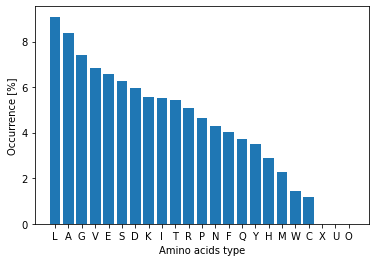

In [33]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.seq, xlabel='Amino acids type').show()

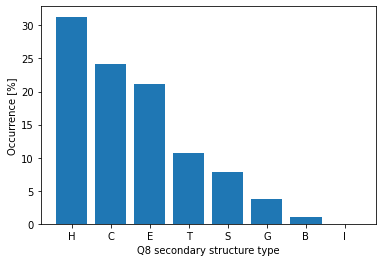

In [34]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.sst_q8, xlabel='Q8 secondary structure type').show()

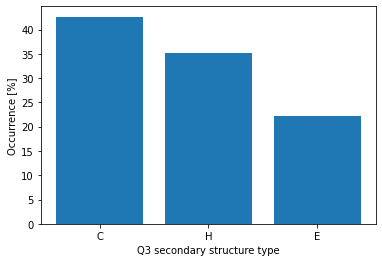

In [35]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.sst_q3, xlabel='Q3 secondary structure type').show()

## __7. Sequences representation for modeling__

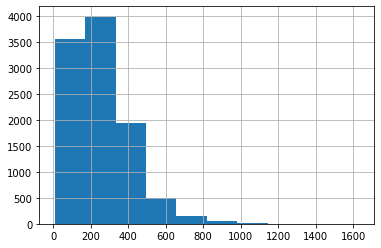

In [36]:
processes_sequeces.length.hist()
plt.show()

Most of the sequences in prepared dataset do not exceed the length of 500 amino acids, hence I will limit the max length to 500 and unify the length of the samples by padding accordingly

In [37]:
maxlen = 500

Now I will prepare sequences for modeling. As my ulimate goal is to use a so called ProtVec embedding obtained on the large dataset for DNA, RNA and Protein sequences (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0141287), I will represent my sequences in the same form of ngrams consisting of 3 consecutive amino acids in the sequence as it was shown to represent the protein sequence well for deep learning applications (https://pubs.acs.org/doi/10.1021/acs.jcim.0c00073).  

In [38]:
from tools import prepare_for_modeling
input_sequences = prepare_for_modeling.convert_to_ngrams(sequences=processes_sequeces.seq, n=3)
X_seq, seq_index = prepare_for_modeling.tokenize_inputs(input_sequences=input_sequences, maxlen=maxlen)
y_sst8, sst8_index = prepare_for_modeling.tokenize_target(target_sst=processes_sequeces.sst_q8, maxlen=maxlen)
y_sst3, sst3_index = prepare_for_modeling.tokenize_target(target_sst=processes_sequeces.sst_q3, maxlen=maxlen)

In [39]:
X_seq.shape, y_sst8.shape, y_sst3.shape

((10184, 500), (10184, 500, 9), (10184, 500, 4))

3 state prediction dataset split 

In [40]:
X_train, X_test, y_train_q3, y_test_q3 = train_test_split(X_seq, y_sst3, test_size=0.2, random_state=42)

In [41]:
X_train.shape, X_test.shape, y_train_q3.shape, y_test_q3.shape

((8147, 500), (2037, 500), (8147, 500, 4), (2037, 500, 4))

In [42]:
# dimensions for simple embeddings
embedding_dims = 500

In [43]:
n_words = len(seq_index) + 1  # including the padding
n_tags = len(sst3_index) + 1  # including the padding
print(n_words, n_tags)

8586 4


Preparation of the above mentioned ProtVec embeddings from external source:


In [44]:
protvec_shape, protvec_embeddings = prepare_for_modeling.parse_protvec_embeddings('../uniref_3M.vec')

In [45]:
protvec_shape

(10180, 1000)

Preparation of the embedding matrix using ProtVec embeddings weights and unique n_grams from my sequences:

In [46]:
embedding_matrix = np.zeros((len(seq_index) + 1, protvec_shape[1]))
for word, i in seq_index.items():
    embedding_vector = protvec_embeddings.get(word.upper())
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [47]:
embedding_matrix.shape

(8586, 1000)

## __8. Building a model__

Now, working on the Q3 secondary structure prediciton, I will test few 
models with various layers.

In [48]:
early_stopping = EarlyStopping(monitor='val_categorical_accuracy',
                              patience=10,
                              restore_best_weights=True)

In [49]:
# LSTM + simple embedding
model1 = Sequential()
model1.add(Embedding(input_shape=(maxlen,), 
                     input_dim=n_words, 
                     output_dim=100, 
                     input_length=maxlen))
model1.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model1.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model1.summary()
model1.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model1_history = model1.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model1.save('../models/model1_lstm_x1.h5')
model1.evaluate(X_test, y_test_q3) 
model1_hist_df = pd.DataFrame(model1_history.history)
with open('../models/model1_lstm_x1_history.csv', 'w') as out:
  model1_hist_df.to_csv(out)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          858600    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 64)           42240     
_________________________________________________________________
time_distributed (TimeDistri (None, 500, 4)            260       
Total params: 901,100
Trainable params: 901,100
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 10s 36ms/step - loss: 0.5442 - categorical_accuracy: 0.7497 - val_loss: 0.4185 - val_categorical_accuracy: 0.8126
Epoch 2/100
204/204 [==============================] - 7s 34ms/step - loss: 0.4151 - categorical_accuracy: 0.8147 - val_loss: 0.4083 - val_categorical_accuracy: 0.8174
Epoch 3/100
204/204 [======================

In [50]:
# 2x LSTM + simple embedding
model2 = Sequential()
model2.add(Embedding(input_shape=(maxlen,), 
                     input_dim=n_words, 
                     output_dim=100, 
                     input_length=maxlen))
model2.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model2.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model2.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model2.summary()
model2.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model2_history = model2.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model2.save('../models/model2_lstm_x2.h5')
model2.evaluate(X_test, y_test_q3) 
model2_hist_df = pd.DataFrame(model2_history.history)
with open('../models/model2_lstm_x2_history.csv', 'w') as out:
  model2_hist_df.to_csv(out)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          858600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 4)            260       
Total params: 1,025,516
Trainable params: 1,025,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 16s 63ms/step - loss: 0.5374 - categorical_accuracy: 0.7349 - val_loss: 0.4235 - val_categorical_accuracy: 0.8091
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - lo

In [51]:
# 2x LSTM + protvec embeddings
model3 = Sequential()
model3.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model3.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model3.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model3.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model3.summary()
model3.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model3_history = model3.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model3.save('../models/model3_lstm_x2_protvec_embeddings.h5')
model3.evaluate(X_test, y_test_q3)
model3_hist_df = pd.DataFrame(model3_history.history)
with open('../models/model3_lstm_x2_protvec_embeddings_history.csv', 'w') as out:
  model3_hist_df.to_csv(out)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 128)          578048    
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 500, 4)            260       
Total params: 9,213,716
Trainable params: 627,716
Non-trainable params: 8,586,000
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 17s 72ms/step - loss: 0.5296 - categorical_accuracy: 0.7645 - val_loss: 0.4341 - val_categorical_accuracy: 0.8034
Epoch 2/100
204/204 [==============================] - 14s 67ms/ste

In [52]:
# 2x LSTM + 2x Dense + protvec embeddings
model4 = Sequential()
model4.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model4.add(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model4.add(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model4.summary()
model4.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model4_history = model4.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model4.save('../models/model4_lstm_x2_dense_x2_protvec_embeddings.h5')
model4.evaluate(X_test, y_test_q3)
model4_hist_df = pd.DataFrame(model4_history.history)
with open('../models/model4_lstm_x2_dense_x2_protvec_embeddings_history.csv', 'w') as out:
  model4_hist_df.to_csv(out)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 128)          578048    
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
dense_3 (Dense)              (None, 500, 64)           4160      
_________________________________________________________________
dense_4 (Dense)              (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 500, 4)            132       
Total params: 9,219,828
Trainable params: 633,828
Non-trainable params: 8,586,000
______________________________________

In [53]:
# BiLSTM + protvec embeddings
model5 = Sequential()
model5.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model5.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model5.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model5.summary()
model5.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model5_history = model5.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model5.save('../models/model5_bilstm_protvec_embeddings.h5')
model5.evaluate(X_test, y_test_q3)
model5_hist_df = pd.DataFrame(model5_history.history)
with open('../models/model5_bilstm_protvec_embeddings_history.csv', 'w') as out:
  model5_hist_df.to_csv(out)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          1156096   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 500, 4)            1028      
Total params: 9,743,124
Trainable params: 1,157,124
Non-trainable params: 8,586,000
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 20s 86ms/step - loss: 0.4793 - categorical_accuracy: 0.7956 - val_loss: 0.4028 - val_categorical_accuracy: 0.8200
Epoch 2/100
204/204 [==============================] - 17s 83ms/step - loss: 0.4008 - categorical_accuracy: 0.8224 - val_loss: 0.3843 - val_categorical_accuracy: 0.8303
Epoch 3/100
204/204 [=======

In [54]:
# 2x BiLSTM + protvec embeddings
model6 = Sequential()
model6.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model6.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model6.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model6.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model6.summary()
model6.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model6_history = model6.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model6.save('../models/model6_bilstm_x2_protvec_embeddings.h5')
model6.evaluate(X_test, y_test_q3)
model6_hist_df = pd.DataFrame(model6_history.history)
with open('../models/model6_bilstm_x2_protvec_embeddings_history.csv', 'w') as out:
  model6_hist_df.to_csv(out)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 256)          1156096   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 500, 4)            516       
Total params: 9,906,964
Trainable params: 1,320,964
Non-trainable params: 8,586,000
_________________________________________________________________
Epoch 1/100
204/204 [==============================] - 30s 121ms/step - loss: 0.4791 - categorical_accuracy: 0.7874 - val_loss: 0.4096 - val_categorical_accuracy: 0.8162
Epoch 2/100
204/204 [==============================] - 23s 115ms

In [112]:
# 2x BiLSTM + 2x Dense + protvec embeddings
model7 = Sequential()
model7.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model7.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model7.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model7.add(Dense(64, activation='relu'))
model7.add(Dense(32, activation='relu'))
model7.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model7.summary()
model7.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model7_history = model7.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model7.save('../models/model7_bilstm_x2_dense_x2_protvec_embeddings.h5')
model7.evaluate(X_test, y_test_q3)
model7_hist_df = pd.DataFrame(model7_history.history)
with open('../models/model7_bilstm_x2_dense_x2_protvec_embeddings_history.csv', 'w') as out:
  model7_hist_df.to_csv(out)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 256)          1156096   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
dense_8 (Dense)              (None, 500, 64)           8256      
_________________________________________________________________
dense_9 (Dense)              (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 500, 4)            132       
Total params: 9,916,916
Trainable params: 1,330,916
Non-trainable params: 8,586,000
____________________________________

In [113]:
# Conv1d + 2x BiLSTM + 2x Dense + protvec embeddings
model8 = Sequential()
model8.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model8.add(Conv1D(256, 3, activation='relu', 
                  padding='same',
                  input_shape=(len(seq_index) + 1,protvec_shape[1])))
model8.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model8.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model8.add(Dense(64, activation='relu'))
model8.add(Dense(32, activation='relu'))
model8.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model8.summary()
model8.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model8_history = model8.fit(X_train,
                            y_train_q3,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model8.save('../models/model8_conv1d_bilstm_x2_dense_x2_protvec_embeddings.h5')
model8.evaluate(X_test, y_test_q3)
model8_hist_df = pd.DataFrame(model8_history.history)
with open('../models/model8_conv1d_bilstm_x2_dense_x2_protvec_embeddings_history.csv', 'w') as out:
  model8_hist_df.to_csv(out)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 256)          768256    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 256)          394240    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
dense_11 (Dense)             (None, 500, 64)           8256      
_________________________________________________________________
dense_12 (Dense)             (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 500, 4)           

Using the best settings obtained so far (model8) I will now also train the model towards more difficult task which is the Q8 secondary structure predition. To do so, I need to prepare train and test sets with Q8 target:

In [114]:
X_train, X_test, y_train_q8, y_test_q8 = train_test_split(X_seq, y_sst8, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train_q8.shape, y_test_q8.shape

((8147, 500), (2037, 500), (8147, 500, 9), (2037, 500, 9))

In [115]:
n_words = len(seq_index) + 1  # including the padding
n_tags = len(sst8_index) + 1  # including the padding
print(n_words, n_tags)

8586 9


In [116]:
# Conv1d + 2x BiLSTM + 2x Dense + protvec embeddings for Q8 structure prediction
model9 = Sequential()
model9.add(Embedding(input_dim = len(seq_index) + 1,
                     output_dim = protvec_shape[1],
                     weights=[embedding_matrix],
                     input_length=maxlen,
                     trainable=False))
model9.add(Conv1D(256, 3, activation='relu', 
                  padding='same',
                  input_shape=(len(seq_index) + 1,protvec_shape[1])))
model9.add(Bidirectional(LSTM(units=128,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model9.add(Bidirectional(LSTM(units=64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                return_sequences=True)))
model9.add(Dense(64, activation='relu'))
model9.add(Dense(32, activation='relu'))
model9.add(TimeDistributed(Dense(n_tags, 
                                 activation="softmax")))
model9.summary()
model9.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy"])
model9_history = model9.fit(X_train,
                            y_train_q8,
                            validation_split=0.2,
                            callbacks=[early_stopping], 
                            epochs=100)
model9.save('../models/model9_conv1d_bilstm_x2_dense_x2_protvec_embeddings_q8.h5')
model9.evaluate(X_test, y_test_q8)
model9_hist_df = pd.DataFrame(model9_history.history)
with open('../models/model9_conv1d_bilstm_x2_dense_x2_protvec_embeddings_q8_history.csv', 'w') as out:
  model9_hist_df.to_csv(out)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 1000)         8586000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 256)          768256    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 500, 256)          394240    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 500, 128)          164352    
_________________________________________________________________
dense_14 (Dense)             (None, 500, 64)           8256      
_________________________________________________________________
dense_15 (Dense)             (None, 500, 32)           2080      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 500, 9)           

## __9. Where is the model making errors?__

In [117]:
loaded_model9 = load_model('../models/model9_conv1d_bilstm_x2_dense_x2_protvec_embeddings_q8.h5')

In [118]:
loaded_model9.evaluate(X_test, y_test_q8)

64/64 [==============================] - 5s 58ms/step - loss: 0.5828 - categorical_accuracy: 0.7893


[0.5827718377113342, 0.7893205881118774]

In [119]:
loaded_model8 = load_model('../models/model8_conv1d_bilstm_x2_dense_x2_protvec_embeddings.h5')

In [120]:
loaded_model8.evaluate(X_test, y_test_q3)

64/64 [==============================] - 5s 59ms/step - loss: 0.3476 - categorical_accuracy: 0.8509


[0.34758684039115906, 0.8509101867675781]

I generate reversed dictionaries of my q3 and q8 indexes for translating my predictions into the reable structure representation for further investigation

In [236]:
def compare_original_predicted(predicted_sst, original_sst):
    success_rate = []
    mistakes = []
    if len(predicted_sst) == len(original_sst):
      for j in np.arange(len(predicted_sst)):
        i = 0
        mistakes_temp = []
        for x, y in zip(predicted_sst[j], original_sst[j]):
          if x == y:
            i += 1
          else:
            mistakes_temp.append(f'{x}-{y}')
        success_rate.append(i/len(predicted_sst[j]))
        mistakes.append(mistakes_temp)
      
      return success_rate, mistakes

In [238]:
reversed_sst3_index = dict([(value, key) for (key, value) in sst3_index.items()])
y_test_pred_q3 = loaded_model8.predict(X_test)
sst3_model_eval_df = pd.DataFrame({'original_sst3': [''.join([reversed_sst3_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_q3],
                                   'predicted_sst3_test': [''.join([reversed_sst3_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_pred_q3]})

In [239]:
reversed_sst8_index = dict([(value, key) for (key, value) in sst8_index.items()])
y_test_pred_q8 = loaded_model9.predict(X_test)
sst8_model_eval_df = pd.DataFrame({'original_sst8': [''.join([reversed_sst8_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_q8],
                                   'predicted_sst8_test': [''.join([reversed_sst8_index[np.argmax(x)] for x in y if np.argmax(x) != 0]) for y in y_test_pred_q8]})

In [230]:
sst3_model_eval_df['correctly_assigned'] = compare_original_predicted(sst3_model_eval_df.predicted_sst3_test, sst3_model_eval_df.original_sst3)[0]
sst3_model_eval_df['mistakes'] = compare_original_predicted(sst3_model_eval_df.predicted_sst3_test, sst3_model_eval_df.original_sst3)[1]

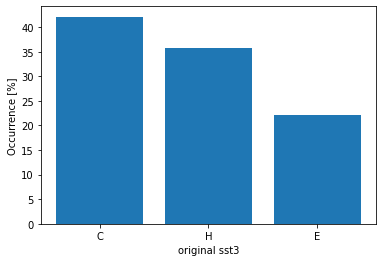

In [278]:
visualizer.visualize_occurrence(feature_series=sst3_model_eval_df.original_sst3, xlabel='original sst3').show()

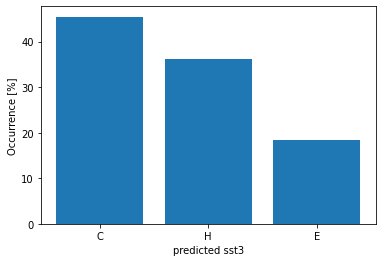

In [279]:
visualizer.visualize_occurrence(feature_series=sst3_model_eval_df.predicted_sst3_test, xlabel='predicted sst3').show()

In [256]:
import itertools
from collections import Counter

In [261]:
sst3_model_eval_df.success_rate.mean()

0.7067071765355641

In [265]:
sst3_mistakes_summary = dict(Counter(list(itertools.chain.from_iterable(sst3_model_eval_df.mistakes.values.tolist()))))

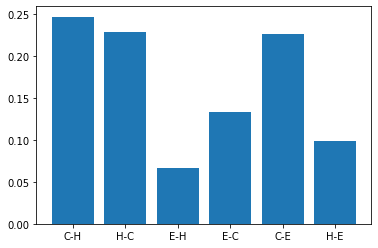

In [277]:
plt.bar(x=np.arange(len(sst3_mistakes_summary)), height=[x/sum(sst3_mistakes_summary.values()) for x in sst3_mistakes_summary.values()]) 
plt.xticks(ticks=np.arange(len(sst3_mistakes_summary)), labels=sst3_mistakes_summary.keys())
plt.show()

In [287]:
sst8_model_eval_df['success_rate'] = compare_original_predicted(sst8_model_eval_df.predicted_sst8_test, sst8_model_eval_df.original_sst8)[0]
sst8_model_eval_df['mistakes'] = compare_original_predicted(sst8_model_eval_df.predicted_sst8_test, sst8_model_eval_df.original_sst8)[1]

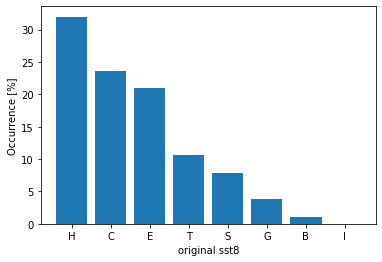

In [288]:
visualizer.visualize_occurrence(feature_series=sst8_model_eval_df.original_sst8, xlabel='original sst8').show()

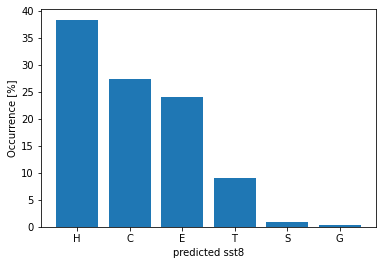

In [289]:
visualizer.visualize_occurrence(feature_series=sst8_model_eval_df.predicted_sst8_test, xlabel='predicted sst8').show()

In [290]:
sst8_model_eval_df.success_rate.mean()

0.5912364313610482

In [291]:
sst8_mistakes_summary = dict(Counter(list(itertools.chain.from_iterable(sst8_model_eval_df.mistakes.values.tolist()))))

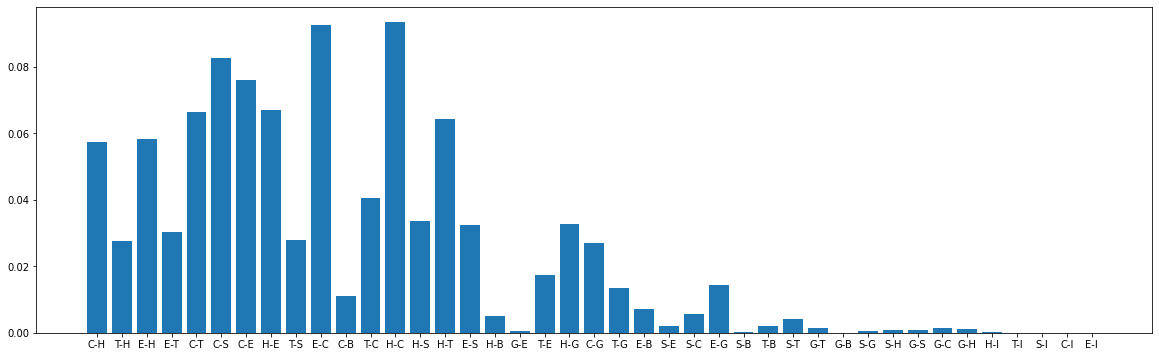

In [294]:
plt.figure(figsize=(20,6))
plt.bar(x=np.arange(len(sst8_mistakes_summary)), height=[x/sum(sst8_mistakes_summary.values()) for x in sst8_mistakes_summary.values()]) 
plt.xticks(ticks=np.arange(len(sst8_mistakes_summary)), labels=sst8_mistakes_summary.keys())
plt.show()

## __10. Summary__

## __11. References__